# mục này là load data crema-d

In [ ]:
!pip install kagglehub


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tranlong0814","key":"a12e7bc7b2f177e577dc431a7226a6c1"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:

import os
import kagglehub

path = kagglehub.dataset_download("akaiinu/crema-d")
print("Path downloaded:", path)

# Kiểm tra xem trong path có gì
print(os.listdir(path))


100%|██████████| 1.14G/1.14G [00:08<00:00, 144MB/s]

Extracting files...


Path downloaded: /root/.cache/kagglehub/datasets/akaiinu/crema-d/versions/1
['cremad']


In [ ]:
!kaggle datasets download -d akaiinu/crema-d
!unzip -q crema-d.zip -d ./crema-d


Dataset URL: https://www.kaggle.com/datasets/akaiinu/crema-d
License(s): MIT
 93% 1.06G/1.14G [00:11<00:02, 43.4MB/s]
100% 1.14G/1.14G [00:11<00:00, 110MB/s] 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
root_dir = "./crema-d/cremad/Image-01-FPS"


In [ ]:
import os, glob, pandas as pd

rows = []
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    # tách nhãn cảm xúc
    parts = folder.split("_")
    if len(parts) < 3:
        continue
    emotion = parts[2]  # ANG, DIS, FEA, HAP, NEU, SAD

    for img_path in glob.glob(os.path.join(folder_path, "*.jpg")):
        rows.append([img_path, emotion])

df = pd.DataFrame(rows, columns=["image_path", "emotion"])
df = df[df['emotion'].isin(['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'])]  # 6 nhãn chính
print("Số lượng ảnh:", len(df))
print("Các nhãn:", sorted(df["emotion"].unique()))
df.head()


Số lượng ảnh: 23299
Các nhãn: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']


,image_path,emotion
0,./crema-d/cremad/Image-01-FPS/1019_TAI_HAP_XX/...,HAP
1,./crema-d/cremad/Image-01-FPS/1019_TAI_HAP_XX/...,HAP
2,./crema-d/cremad/Image-01-FPS/1019_TAI_HAP_XX/...,HAP
3,./crema-d/cremad/Image-01-FPS/1028_IOM_NEU_XX/...,NEU
4,./crema-d/cremad/Image-01-FPS/1028_IOM_NEU_XX/...,NEU


In [ ]:
# Import libraries
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 40, 40
import random

In [ ]:
from google.colab import drive
import shutil

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Đường dẫn muốn lưu trên Drive
drive_path = '/content/drive/MyDrive/CREMA-D'  # bạn có thể đổi tên thư mục

# 3. Copy toàn bộ thư mục CREMA-D vào Drive
shutil.copytree('./crema-d', drive_path)

print("Đã lưu xong vào Drive:", drive_path)


KeyboardInterrupt: 

In [ ]:

emotions = sorted(df["emotion"].unique())
emo2idx = {emo: i for i, emo in enumerate(emotions)}
df["label"] = df["emotion"].map(emo2idx)
print(emo2idx)


{'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'NEU': 4, 'SAD': 5}


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

# Map nhãn
emotion_to_label = {'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'NEU': 4, 'SAD': 5}

# Transform ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # chuẩn ImageNet
                         std=[0.229, 0.224, 0.225])
])

# Dataset
class CREMADataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        label = emotion_to_label[row['emotion']]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

# Split train/test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)

train_dataset = CREMADataset(train_df, transform=transform)
test_dataset = CREMADataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 18639, Test samples: 4660


#Trích xuất feature từu resnet18

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms

# Load ResNet18 pretrained
resnet = models.resnet18(weights='IMAGENET1K_V1')

# Bỏ fully-connected (fc) → chỉ lấy feature 512-D
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

# Nếu có GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
import numpy as np

def extract_features(dataloader):
    features = []
    labels = []

    with torch.no_grad():
        for imgs, labs in dataloader:
            imgs = imgs.to(device)
            outputs = resnet(imgs)                  # (B, 512, 1, 1)
            outputs = outputs.view(outputs.size(0), -1)  # flatten to (B, 512)

            features.append(outputs.cpu().numpy())
            labels.append(labs.numpy())

    return np.concatenate(features), np.concatenate(labels)


In [ ]:
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

print("Train features:", train_features.shape)
print("Test features:", test_features.shape)


Train features: (18639, 512)
Test features: (4660, 512)


In [ ]:
import numpy as np

# Đường dẫn thư mục trong Drive
save_path = "/content/drive/MyDrive/CREMA-D/"  # đổi thành thư mục bạn muốn

# Tạo thư mục nếu chưa có
import os
os.makedirs(save_path, exist_ok=True)

# Lưu train
np.save(save_path + "train_features.npy", train_features)
np.save(save_path + "train_labels.npy", train_labels)

# Lưu test
np.save(save_path + "test_features.npy", test_features)
np.save(save_path + "test_labels.npy", test_labels)

print("Đã lưu train/test features vào Drive!")


Đã lưu train/test features vào Drive!


#Training SVM on ResNet18 features

In [ ]:
from sklearn import svm, metrics

clf = svm.SVC(kernel="rbf", gamma="scale", C=10)

print("Training SVM on ResNet18 features...")
clf.fit(train_features, train_labels)

print("Predicting...")
pred = clf.predict(test_features)

print(metrics.classification_report(test_labels, pred))
print(metrics.confusion_matrix(test_labels, pred))


Training SVM on ResNet18 features...
Predicting...
              precision    recall  f1-score   support

           0       0.41      0.48      0.44       806
           1       0.62      0.63      0.63       868
           2       0.44      0.41      0.43       785
           3       0.64      0.59      0.62       739
           4       0.48      0.47      0.47       653
           5       0.38      0.38      0.38       809

    accuracy                           0.49      4660
   macro avg       0.50      0.49      0.49      4660
weighted avg       0.50      0.49      0.50      4660

[[384  66 104  66  71 115]
 [ 81 549  78  54  28  78]
 [143  94 323  30  60 135]
 [ 86  51  42 438  66  56]
 [ 96  36  58  53 305 105]
 [143  87 124  44 105 306]]


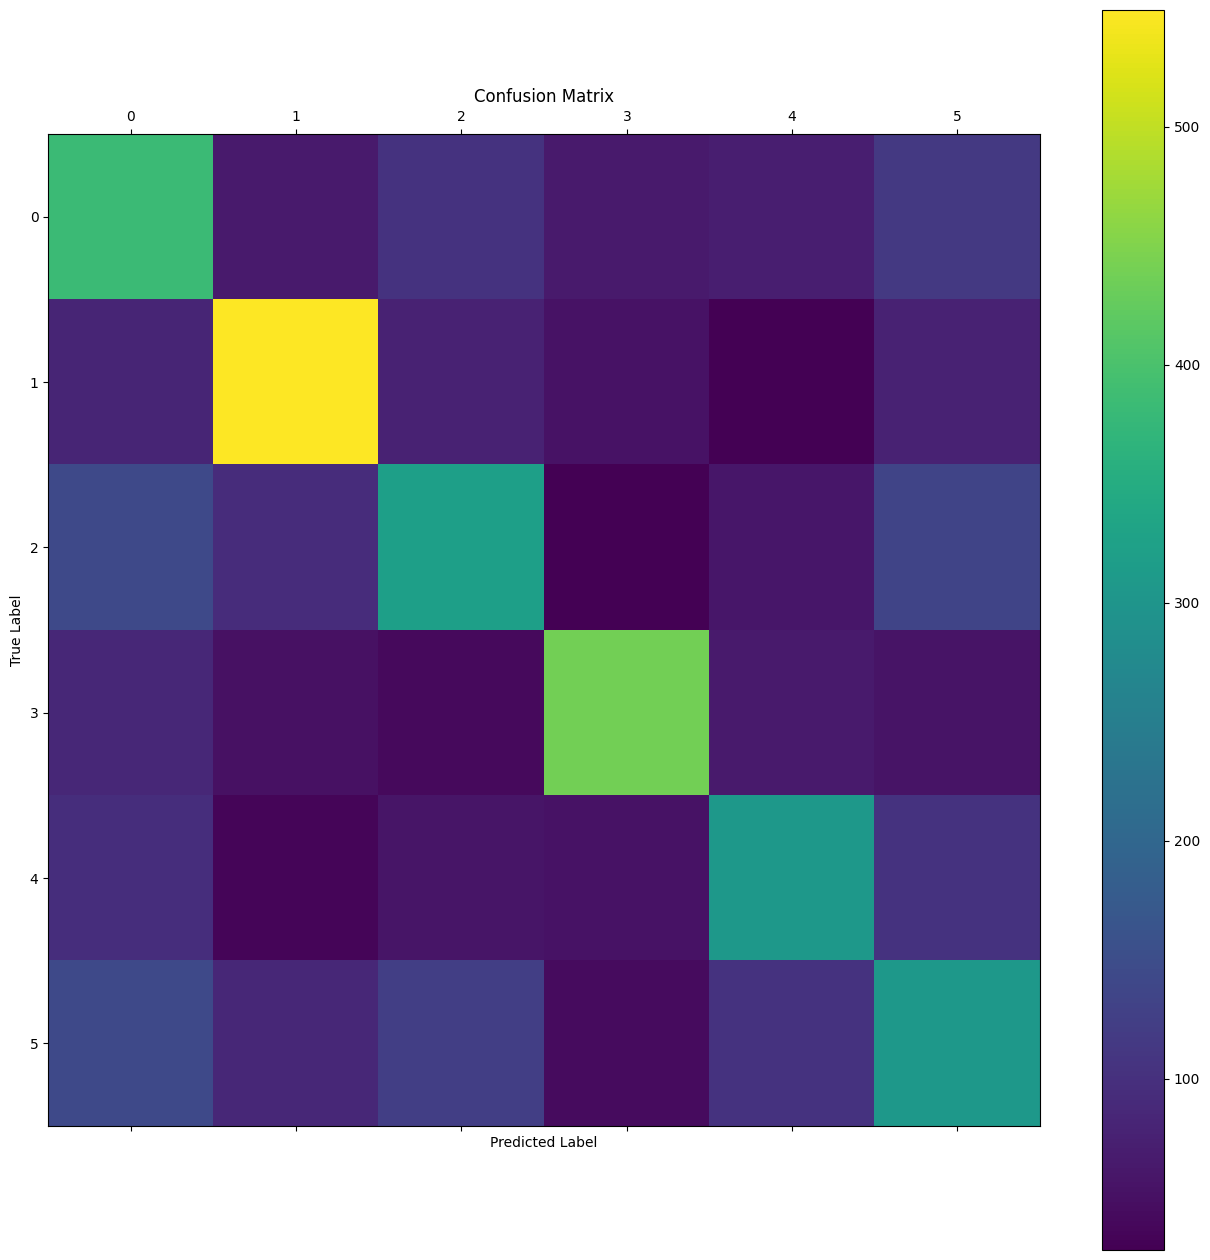

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, pred)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


PHẦN 1 — LẤY TẤT CẢ ẢNH VÀ NHÃN TỪ test_loader

In [ ]:

import torch

all_imgs = []
all_labels = []

for imgs, labels in test_loader:
    all_imgs.append(imgs)
    all_labels.append(labels)

all_imgs = torch.cat(all_imgs)      # (N_test, 3, 224, 224)
all_labels = torch.cat(all_labels)  # (N_test,)

all_preds = pred               # từ SVM, kích thước = N_test


PHẦN 2 — CHỌN NGẪU NHIÊN ẢNH VÀ HIỂN THỊ DỰ ĐOÁN

4660 4660 4660


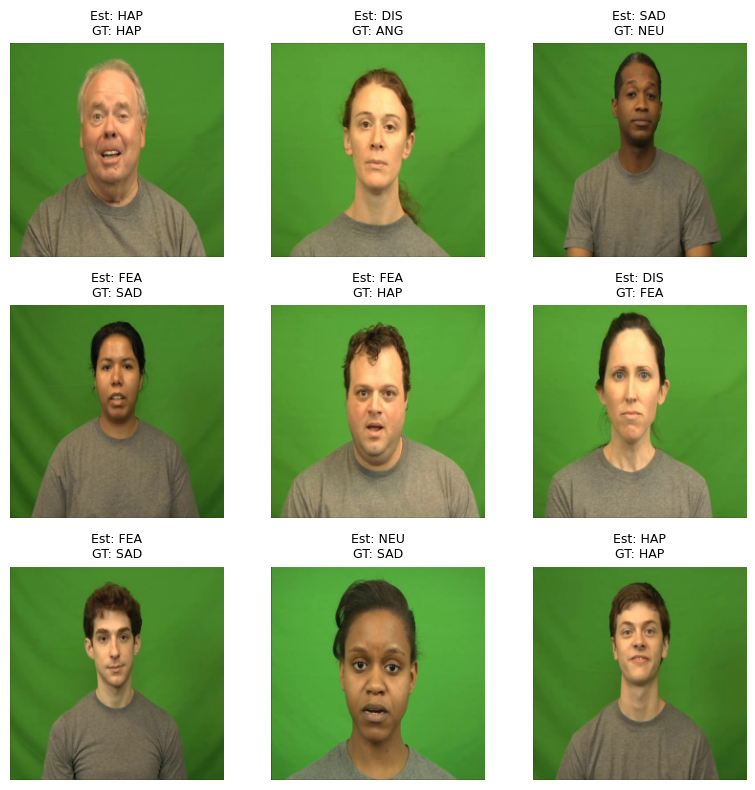

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# N = 3
# fig, axs = plt.subplots(N, N, figsize=(8,8))

# Lấy tất cả ảnh và nhãn từ test_loader
all_imgs = []
all_labels = []

for imgs, labels in test_loader:
    all_imgs.append(imgs)
    all_labels.append(labels)

all_imgs = torch.cat(all_imgs)       # (N_test, 3, 224, 224)
all_labels = torch.cat(all_labels)   # (N_test,)

# all_preds = pred (numpy array từ SVM)
all_preds = pred

print(len(all_imgs), len(all_labels), len(all_preds))  # kiểm tra phải giống nhau
int_to_emotion = {v: k for k, v in emotion_to_label.items()}
N = 3
fig, axs = plt.subplots(N, N, figsize=(8,8))

for i in range(N):
    for j in range(N):
        idx = random.randint(0, len(all_imgs)-1)
        img = all_imgs[idx].permute(1,2,0).numpy()
        img = (img * np.array([0.229,0.224,0.225])) + np.array([0.485,0.456,0.406])
        img = np.clip(img, 0, 1)

        gt = all_labels[idx].item()
        pred_label = all_preds[idx]

        axs[i, j].imshow(img)
        axs[i, j].set_title(f"Est: {int_to_emotion[pred_label]}\nGT: {int_to_emotion[gt]}", fontsize=9)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()



🎯 PHẦN 3 — TỰ ĐỘNG TÍNH C VÀ GAMMA

In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np

def auto_gamma(X, sample_size=2000):
    # lấy ngẫu nhiên 2k mẫu để tính nhanh
    n = min(sample_size, len(X))
    idx = np.random.choice(len(X), n, replace=False)
    X_sub = X[idx]

    # tính khoảng cách pairwise
    dists = pairwise_distances(X_sub, X_sub, metric="euclidean")
    median_dist = np.median(dists)

    gamma = 1 / (2 * (median_dist ** 2))
    return gamma


In [ ]:
def auto_C(X):
    return 1 / np.mean(np.var(X, axis=0))


In [ ]:
def auto_svm_params(X):
    gamma = auto_gamma(X)
    C = auto_C(X)
    return C, gamma


🎯 PHẦN 4 — TRAIN SVM với bộ tham số C, gamma tốt hơn

In [ ]:
C, gamma = auto_svm_params(train_features)

from sklearn.svm import SVC
best_SVM = SVC(C=C, gamma=gamma)
best_SVM.fit(train_features, train_labels)


SVC(C=np.float32(10.788701), gamma=np.float32(0.0057379575))

In [ ]:
predicted = best_SVM.predict(test_features)


expected = test_labels

print("Classification report for classifier %s:\n%s\n"
      % (best_SVM, metrics.classification_report(expected, predicted)))

Classification report for classifier SVC(C=np.float32(10.788701), gamma=np.float32(0.0057379575)):
              precision    recall  f1-score   support

           0       0.43      0.50      0.47       806
           1       0.64      0.65      0.64       868
           2       0.48      0.44      0.46       785
           3       0.66      0.60      0.63       739
           4       0.50      0.51      0.50       653
           5       0.44      0.42      0.43       809

    accuracy                           0.52      4660
   macro avg       0.52      0.52      0.52      4660
weighted avg       0.53      0.52      0.52      4660




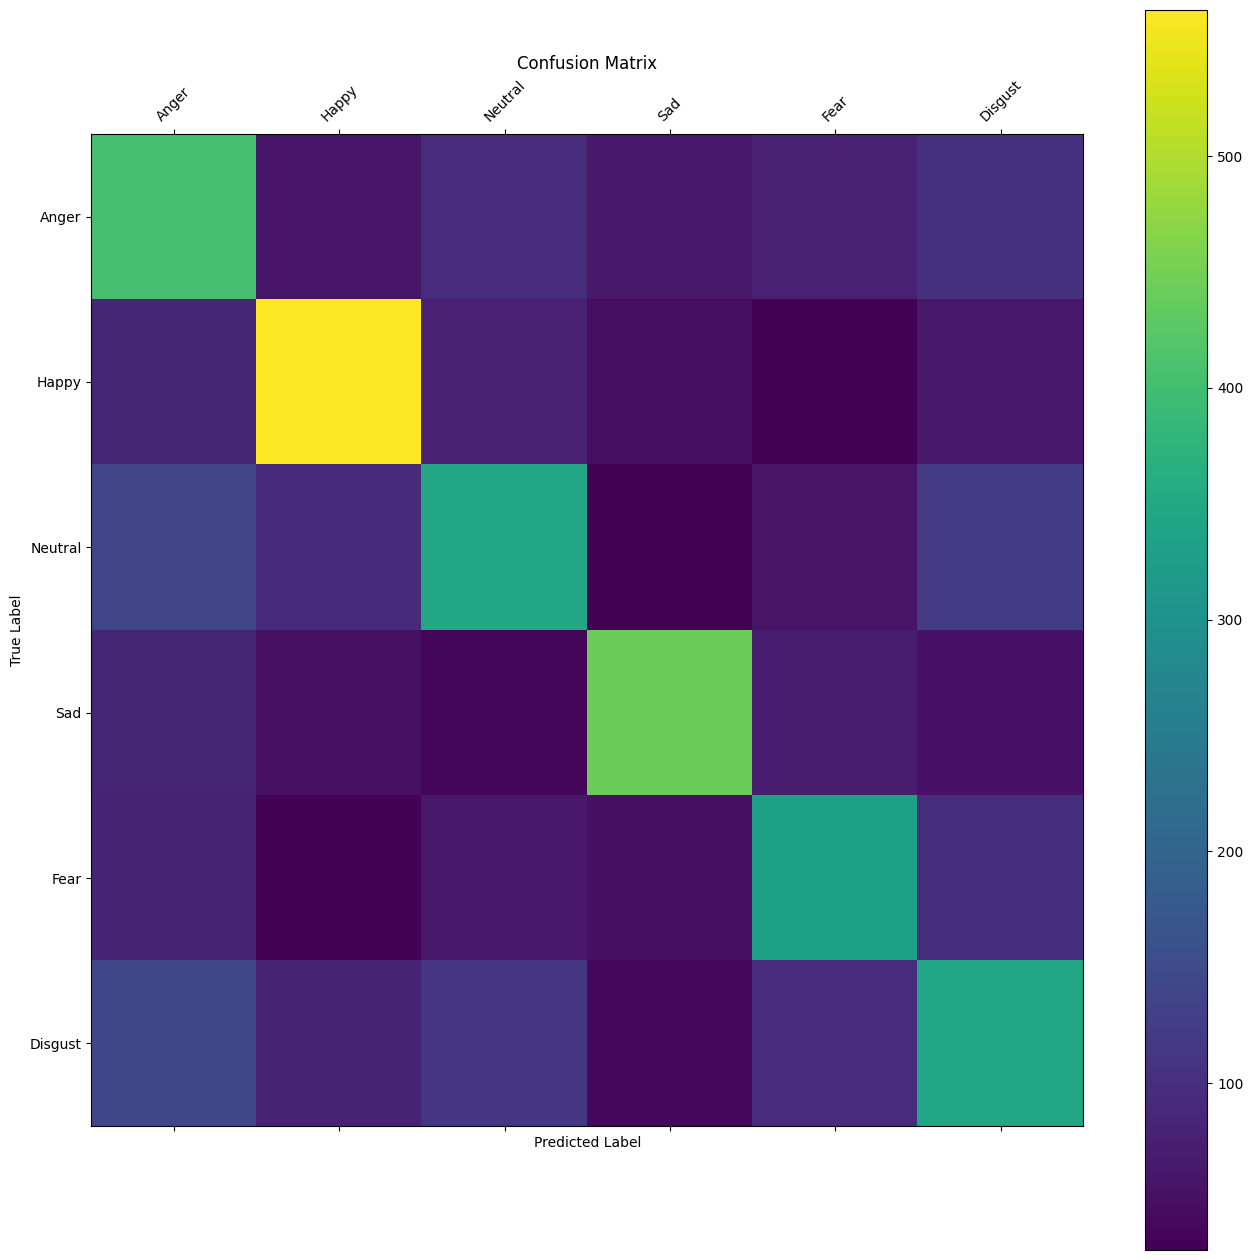

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, predicted)

plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

emotion_to_int = {
    0: "Anger",
    1: "Happy",
    2: "Neutral",
    3: "Sad",
    4: "Fear",
    5: "Disgust"
}

plt.xticks(ticks=range(6), labels=emotion_to_int.values(), rotation=45)
plt.yticks(ticks=range(6), labels=emotion_to_int.values())
plt.show()


In [ ]:
print(type(test_dataset))
print(type(test_dataset[0]))
print(test_dataset[0])


<class '__main__.CREMADataset'>
<class 'tuple'>
(tensor([[[-1.2617, -1.1247, -1.1760,  ..., -1.0390, -1.0390, -1.0390],
         [-1.0733, -0.9192, -0.9705,  ..., -0.8507, -0.8507, -0.8507],
         [-1.0733, -0.9534, -0.9877,  ..., -0.8678, -0.8678, -0.8849],
         ...,
         [-1.4500, -1.3473, -1.3302,  ..., -1.3644, -1.3644, -1.3644],
         [-1.4500, -1.3302, -1.2959,  ..., -1.3473, -1.3473, -1.3473],
         [-1.5699, -1.4500, -1.4329,  ..., -1.4843, -1.4843, -1.4843]],

        [[-0.1800,  0.0301,  0.0126,  ...,  0.0476,  0.0476,  0.0476],
         [ 0.0476,  0.2577,  0.2402,  ...,  0.2577,  0.2577,  0.2577],
         [ 0.0476,  0.2402,  0.2402,  ...,  0.2577,  0.2577,  0.2577],
         ...,
         [-0.5301, -0.4076, -0.3725,  ..., -0.4426, -0.4426, -0.4426],
         [-0.5476, -0.4251, -0.4076,  ..., -0.4601, -0.4601, -0.4601],
         [-0.7052, -0.5826, -0.5651,  ..., -0.6176, -0.6176, -0.6176]],

        [[-1.3687, -1.2467, -1.2990,  ..., -1.2467, -1.2467, -1.246

# Hiển thị ảnh test + dự đoán SVM

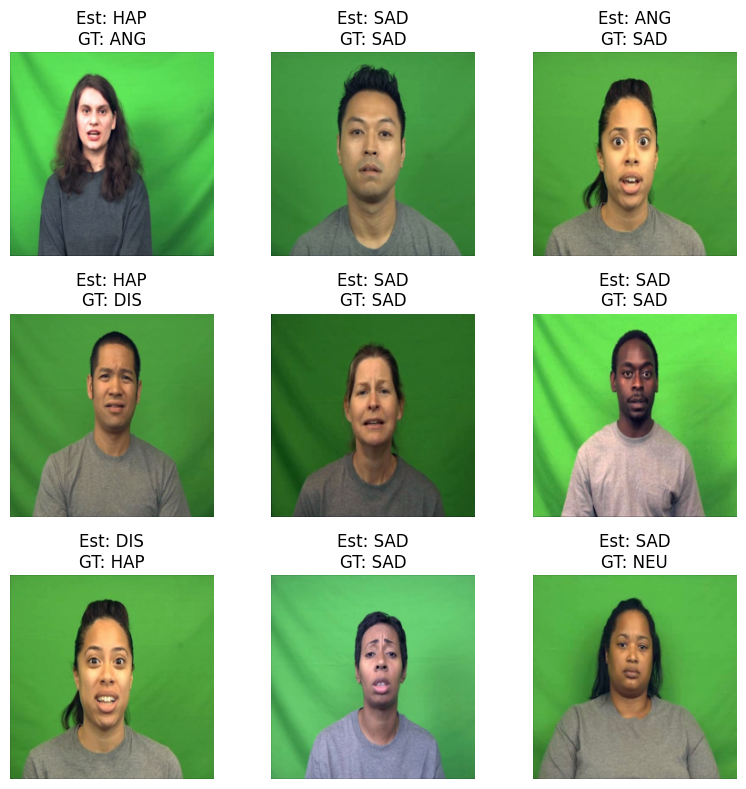

In [ ]:
import random
import matplotlib.pyplot as plt

N = 3
fig, axs = plt.subplots(N, N, figsize=(8, 8))

for i in range(N):
    for j in range(N):
        idx = random.randint(0, len(test_dataset) - 1)

        img_tensor, true_label = test_dataset[idx]

        # Chuyển từ tensor sang numpy
        img = img_tensor.numpy()

        # Chuyển từ (C, H, W) -> (H, W, C)
        img = img.transpose(1, 2, 0)

        # Nếu normalized, chuyển về [0,1] để hiển thị
        img = (img - img.min()) / (img.max() - img.min())

        pred_label = predicted[idx]

        axs[i, j].imshow(img)
        axs[i, j].set_title(
            f"Est: {int_to_emotion[pred_label]}\nGT: {int_to_emotion[true_label]}"
        )
        axs[i, j].axis("off")

plt.tight_layout()
plt.show()


#CELL 1 — Khởi tạo MLPClassifier

In [ ]:
# from sklearn.neural_network import MLPClassifier

# mlp_classifier = MLPClassifier(solver='lbfgs',max_iter=500, alpha=1e-5, hidden_layer_sizes=(1000, 200), random_state=1, verbose=True)

# print(mlp_classifier)
# # alpha: L2 penalty (regularization term) parameter.
# # beta_1, beta_2: parameters for first-order and second-order moments of Adam
# # loss: cross-entropy loss.

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    solver='adam',          # ✓ nhanh, ổn định hơn lbfgs
    hidden_layer_sizes=(256, 128),
    max_iter=200,
    activation='relu',
    batch_size=64,
    learning_rate_init=1e-3,
    verbose=True,
    random_state=42
)

mlp.fit(train_features, train_labels)
predicted = mlp.predict(test_features)


Iteration 1, loss = 1.75709519
Iteration 2, loss = 1.67649506
Iteration 3, loss = 1.64159734
Iteration 4, loss = 1.60617018
Iteration 5, loss = 1.59080571
Iteration 6, loss = 1.56049582
Iteration 7, loss = 1.53051053
Iteration 8, loss = 1.51159929
Iteration 9, loss = 1.50124394
Iteration 10, loss = 1.50242215
Iteration 11, loss = 1.47302734
Iteration 12, loss = 1.46355183
Iteration 13, loss = 1.44527188
Iteration 14, loss = 1.43494206
Iteration 15, loss = 1.42858381
Iteration 16, loss = 1.41818877
Iteration 17, loss = 1.40331885
Iteration 18, loss = 1.38995133
Iteration 19, loss = 1.37256490
Iteration 20, loss = 1.36747679
Iteration 21, loss = 1.35142604
Iteration 22, loss = 1.35123737
Iteration 23, loss = 1.34264311
Iteration 24, loss = 1.32610642
Iteration 25, loss = 1.31397323
Iteration 26, loss = 1.31083380
Iteration 27, loss = 1.30206007
Iteration 28, loss = 1.29762394
Iteration 29, loss = 1.28776969
Iteration 30, loss = 1.27034802
Iteration 31, loss = 1.26491696
Iteration 32, los

CELL 2 — In accuracy + classification report

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(test_labels, predicted)
print("Accuracy:", acc)


Accuracy: 0.47296137339055794


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

predicted = mlp.predict(test_features)

print("Accuracy:", accuracy_score(test_labels, predicted))
print(classification_report(test_labels, predicted))


Accuracy: 0.47296137339055794
              precision    recall  f1-score   support

           0       0.37      0.46      0.41       806
           1       0.61      0.57      0.59       868
           2       0.47      0.38      0.42       785
           3       0.56      0.61      0.58       739
           4       0.47      0.42      0.44       653
           5       0.39      0.39      0.39       809

    accuracy                           0.47      4660
   macro avg       0.48      0.47      0.47      4660
weighted avg       0.48      0.47      0.47      4660



In [ ]:
# mlp_classifier.fit(train_features, train_labels)
# predicted = mlp_classifier.predict(test_features)


In [ ]:
print("Classification report for classifier %s:\n%s\n"
      % (mlp, metrics.classification_report(expected, predicted)))

Classification report for classifier MLPClassifier(batch_size=64, hidden_layer_sizes=(256, 128), random_state=42,
              verbose=True):
              precision    recall  f1-score   support

           0       0.37      0.46      0.41       806
           1       0.61      0.57      0.59       868
           2       0.47      0.38      0.42       785
           3       0.56      0.61      0.58       739
           4       0.47      0.42      0.44       653
           5       0.39      0.39      0.39       809

    accuracy                           0.47      4660
   macro avg       0.48      0.47      0.47      4660
weighted avg       0.48      0.47      0.47      4660




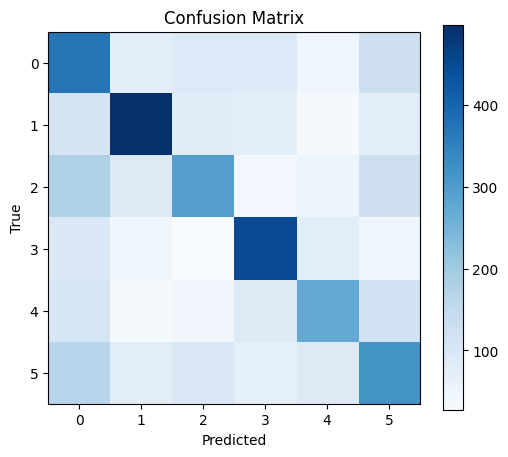

In [ ]:
plt.figure(figsize=(6,5))
plt.imshow(confusion_matrix(test_labels, predicted), cmap="Blues")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
test_images = []
test_labels_list = []

for imgs, lbls in test_loader:
    for img, lbl in zip(imgs, lbls):
        test_images.append(img)       # ảnh tensor C×H×W
        test_labels_list.append(lbl)  # label


#CELL 3 — Hiển thị lại ảnh test với label predict

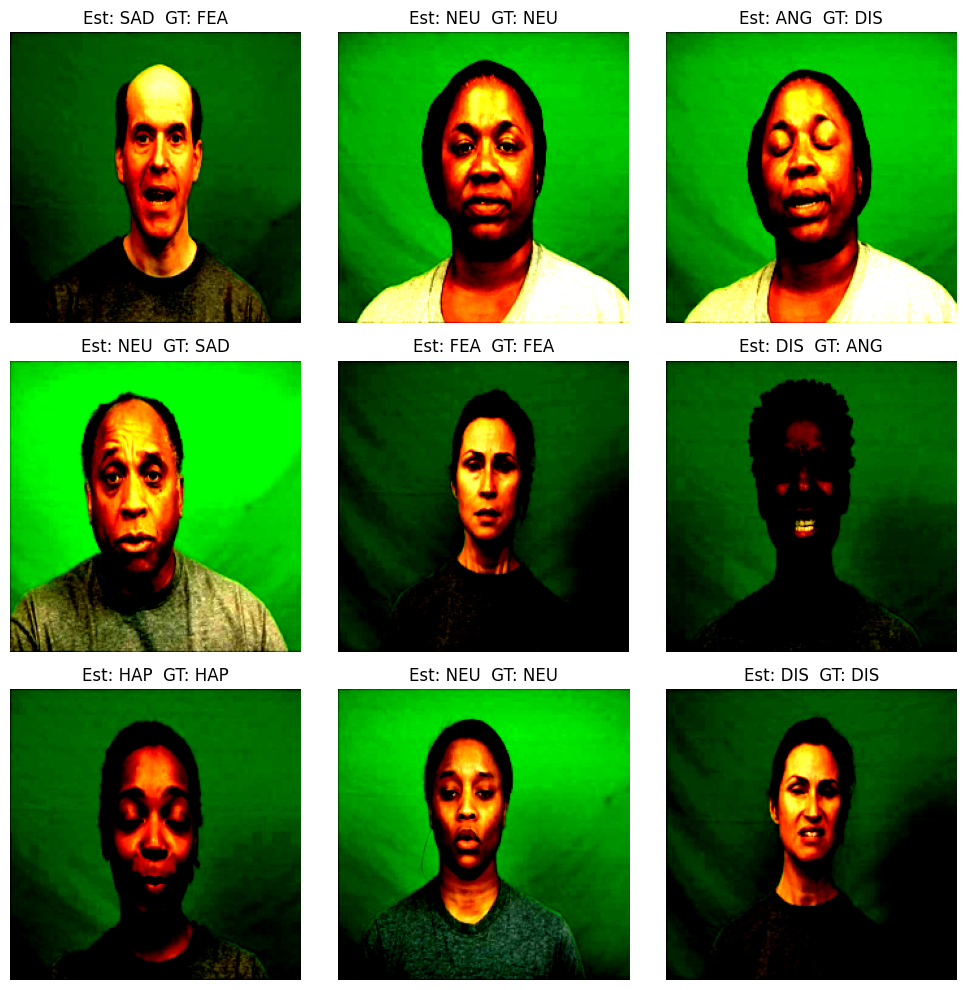

In [ ]:
import random
import matplotlib.pyplot as plt

N = 3
fig, axs = plt.subplots(N, N, figsize=(10, 10))

for i in range(N):
    for j in range(N):
        index = random.randint(0, len(test_images)-1)

        # lấy ảnh (tensor C×H×W)
        img = test_images[index]
        img = img.permute(1, 2, 0).cpu().numpy()   # chuyển thành H×W×C

        # nhãn thật
        gt = test_labels_list[index]

        # nhãn dự đoán
        pred = predicted[index]

        axs[i, j].imshow(img)
        axs[i, j].set_title(
            f"Est: {int_to_emotion[pred]}  GT: {int_to_emotion[int(gt)]}"
        )
        axs[i, j].axis("off")

plt.tight_layout()
plt.show()
